In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("FinalCoursework") \
    .config("spark.driver.memory", "4g")\
    .getOrCreate()

sc = spark.sparkContext

In [2]:
dir_path="/mnt/data/project-data/2020tweets"

df_trump = spark.read.option("multiline", True).csv("/hashtag_donaldtrump.csv", header=True, inferSchema=True)
df_biden = spark.read.option("multiline", True).csv("/hashtag_joebiden.csv", header=True, inferSchema=True)

In [3]:
def transer_data_type(data):
  data = data.withColumn("likes", data["likes"].cast("int"))
  data = data.withColumn("retweet_count", data["retweet_count"].cast("int"))
  data = data.withColumn("user_followers_count", data["user_followers_count"].cast("int"))
  data = data.withColumn("lat", data["lat"].cast("float"))
  data = data.withColumn("long", data["long"].cast("float"))
  return data

df_trump = transer_data_type(df_trump)
df_biden = transer_data_type(df_biden)

In [4]:
#Dropping columns
remove_columns = ['created_at', 'tweet_id', 'user_id', 'user_screen_name', 'user_join_date', 'collected_at', 'user_name', 'user_description', 'user_location', 'lat', 'long', 'city', 'country', 'continent', 'state', 'state_code']
df_trump = df_trump.drop(*remove_columns)
df_biden = df_biden.drop(*remove_columns)

#Dropping rows with na values
df_trump = df_trump.na.drop()
df_biden = df_biden.na.drop()

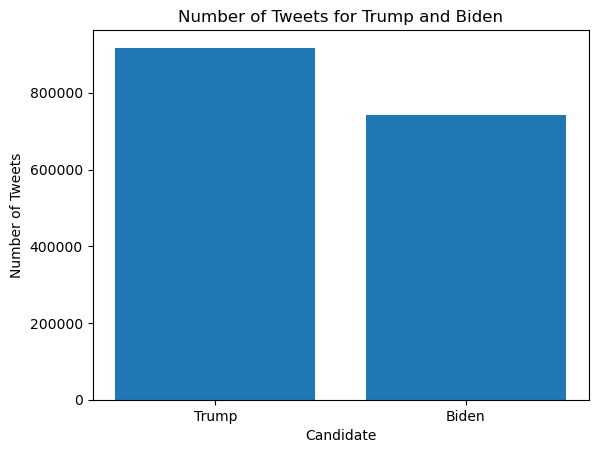

In [5]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.bar(['Trump', 'Biden'], [df_trump.count(), df_biden.count()])
plt.xlabel('Candidate')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets for Trump and Biden')
plt.show()

In [6]:
from pyspark.sql.functions import lit

#Adding a presidents column where 0 represents trump and 1 represents biden. This will turn it into a classification problem
df_trump = df_trump.withColumn('President', lit(0))
df_biden = df_biden.withColumn('President', lit(1))

#Merging the 2 datasets
df = df_trump.union(df_biden)

In [7]:
df.show(5)

+--------------------+-----+-------------+------------------+--------------------+---------+
|               tweet|likes|retweet_count|            source|user_followers_count|President|
+--------------------+-----+-------------+------------------+--------------------+---------+
|#Elecciones2020 |...|    0|            0|         TweetDeck|                1860|        0|
|Usa 2020, Trump c...|   26|            9|  Social Mediaset |             1067661|        0|
|#Trump: As a stud...|    2|            1|   Twitter Web App|                1185|        0|
|2 hours since las...|    0|            0|     Trumpytweeter|                  32|        0|
|You get a tie! An...|    4|            3|Twitter for iPhone|                5393|        0|
+--------------------+-----+-------------+------------------+--------------------+---------+


In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from collections import Counter
import re

#Extracts all the hastags from the tweet and stores them in a list
@udf(returnType=ArrayType(StringType()))
def getHashtagList(tweet):
  tweet = tweet.lower()
  tweet = re.sub(r'[^\w\s#]', '', tweet)
  hashtag_list = []

  for word in tweet.split():
    if word[0] == '#':
      hashtag_list.append(word)
  
  #Creates a dictionary where the hashtags are the key and their frequency in the list is the value
  count_hashtags = Counter(hashtag_list)

  #Remove duplicate hashtags
  unique_hashtags = [hashtag for hashtag, frequency in count_hashtags.items() if frequency == 1]

  return hashtag_list

#Creates a column called hashtags which stores a hastag list for all the tweets
df = df.withColumn('hashtags', getHashtagList(df['tweet']))

In [9]:
df.show(5)

+--------------------+-----+-------------+------------------+--------------------+---------+--------------------+
|               tweet|likes|retweet_count|            source|user_followers_count|President|            hashtags|
+--------------------+-----+-------------+------------------+--------------------+---------+--------------------+
|#Elecciones2020 |...|    0|            0|         TweetDeck|                1860|        0|[#elecciones2020,...|
|Usa 2020, Trump c...|   26|            9|  Social Mediaset |             1067661|        0|      [#donaldtrump]|
|#Trump: As a stud...|    2|            1|   Twitter Web App|                1185|        0|            [#trump]|
|2 hours since las...|    0|            0|     Trumpytweeter|                  32|        0|            [#trump]|
|You get a tie! An...|    4|            3|Twitter for iPhone|                5393|        0|     [#trump, #iowa]|
+--------------------+-----+-------------+------------------+--------------------+------

In [10]:
from pyspark.sql import functions as F
from pyspark.sql.functions import count
    
#Splits the hashtag list and displays each hashtag in its own row in column hashtag
df_exploded = df.withColumn('hashtag', F.explode(df['hashtags']))

#Analyze hashtag
df_hashtag=df_exploded.select('hashtag')

# 对name列进行分组，并计算每个分组的行数
grouped_df = df_hashtag.groupBy("hashtag").agg(count("*").alias("counts"))
# 将计数结果作为新列加入到原始DataFrame中
df_hashtag = df_hashtag.join(grouped_df, ["hashtag"], "inner")
# 去除基于name列的重复行
df_hashtag = df_hashtag.dropDuplicates(["hashtag"])
# 按照count列进行降序排序
df_hashtag = df_hashtag.orderBy("counts", ascending=False)

# 显示排序后的结果
df_hashtag.show(truncate=False)



+----------------+------+
|hashtag         |counts|
+----------------+------+
|#trump          |968674|
|#biden          |631862|
|#joebiden       |335308|
|#election2020   |172108|
|#donaldtrump    |166046|
|#elections2020  |99443 |
|#bidenharris2020|78352 |
|#trump2020      |74717 |
|#vote           |67982 |
|#electionday    |64120 |
|#usa            |57928 |
|#maga           |46019 |
|#covid19        |43344 |
|#kamalaharris   |41743 |
|#electionnight  |37855 |
|#biden2020      |35942 |
|#uselection2020 |35896 |
|#bidenharris    |31423 |
|#elecciones2020 |30880 |
|#america        |30190 |
+----------------+------+


In [11]:
#分为三类标签 并根据出现次数排序 splite diff type hashtag 
#1.#trump #donaldtrump #trump2020 #maga 
trump=['#trump','#donaldtrump','#trump2020''#maga']

#2 #biden #joebiden #bidenharris2020 #biden2020 #bidenharris
biden=['#biden','#joebiden','#bidenharris2020','#biden2020','#bidenharris']

#3 #election2020 #elections2020 #electionnight #vote #electionday #usa #covid19 #electionnight #uselection2020 #america
normal=['#election2020','#elections2020','#electionnight','#vote','#electionday','#usa','#covid19','#electionnight','#uselection2020','#america']

In [12]:
#Creates a new column called count which displays how many rows the hashtag appears in
#The counts will be used in TF-IDF calculation
df_count = df_exploded.groupBy("hashtag").count()

#Renaming count to hashtag_count
df_count = df_count.withColumnRenamed('count', 'hashtag_count')

#Joining df_count with df_exploded on hashtag
df_exploded = df_exploded.join(df_count, on="hashtag", how="left")

# Group by original columns and collect list of counts
df = df_exploded.groupBy(df.columns).agg(F.collect_list("hashtag_count").alias("hashtag_counts"))

In [13]:
df.show(5)

+--------------------+-----+-------------+-------------------+--------------------+---------+--------------------+--------------------+
|               tweet|likes|retweet_count|             source|user_followers_count|President|            hashtags|      hashtag_counts|
+--------------------+-----+-------------+-------------------+--------------------+---------+--------------------+--------------------+
| He’s nothing mor...|    0|            0|    Twitter Web App|                  71|        0|            [#trump]|            [968674]|
| it shows that #t...|    1|            0|Twitter for Android|                  11|        0|            [#trump]|            [968674]|
| media-sourced po...|    0|            0|Twitter for Android|                 657|        0|            [#biden]|            [631862]|
| mientras hace ca...|    0|            0| Twitter for iPhone|                  14|        1|[#electionday, #d...|[631862, 78352, 6...|
| so Please get a ...|    0|            0|Twitte

In [14]:
#Total number of rows
#This value is used to calculate TF-IDF
df_count = df.count()
print(df_count)

1643761


In [15]:
from pyspark.sql.types import FloatType
import math

#Creates the TF_IDF list column
@udf(returnType=FloatType())
def getAvg_TF_IDF(hashtags, hashtag_counts, df_count):
  avg_TF_IDF = 0
  count = 0

  #If there are no hashtags the tweet will be given a value of 0
  if len(hashtags) == 0:
    return 0.0

  for hashtag in hashtags:
      
    #Calculating TF
    #Since all the hastags are unique 1 is being divided by the total number of hastags
    TF = 1 / len(hashtags)
    #nDocs is the number of rows/tweets the hastag is used
    nDocs = hashtag_counts[count]
    #Calculating IDF
    #df_count is the total number of rows/tweets
    IDF = math.log(df_count / nDocs)

    TF_IDF = TF * IDF
    
    #polarity for hashtag
    if hashtag in biden:
      TF_IDF=TF_IDF*-1
    elif hashtag in trump:
      TF_IDF=TF_IDF*1
    else:
      TF_IDF=0
        
    avg_TF_IDF += TF_IDF
    count += 1

  avg_TF_IDF /= count
  return avg_TF_IDF

# Apply the UDF to your DataFrame
df = df.withColumn('TF_IDF', getAvg_TF_IDF(df['hashtags'], df['hashtag_counts'], lit(df_count)))

In [16]:
df.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-------------+--------------------+--------------------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------+------------+
|tweet                                                                                                                                                                                                                         

In [17]:
import re,string
# This code defines a function named "tokenize" that tokenizes the input text.
# It removes special characters, converts the text to lowercase, and removes stopwords and punctuation.
# The resulting tokens are added to a list and returned.

# This code defines a list of stopwords to be removed from the text.
stopwords = [u'rt', u're', u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your',
             u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers',
             u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what',
             u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were',
             u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a',
             u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by',
             u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after',
             u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under',
             u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all',
             u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u'not',
             u'only', u'own', u'same', u'so', u'than', u'too', u'very', u's', u't', u'can', u'will', u'just', u'don',
             u'should', u'now']
def tokenize(text):
    # Remove URLs
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove special characters
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Split text into tokens and filter out stopwords, single characters, and '``'
    tokens = [word for word in text.split() if word not in stopwords and len(word) > 1 and word != '``']
    
    return tokens

In [18]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sc.broadcast(sia)

def calculate_sentiment(text):
    #sia = SentimentIntensityAnalyzer()
    if isinstance(text, list):
        text = ' '.join(text)
    sentiment_scores = sia.polarity_scores(text)['compound']

    return sentiment_scores

[nltk_data] Downloading package vader_lexicon to C:\Users\ALLEN
[nltk_data]     AN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
from pyspark.sql.types import *

# Define UDF to tokenize the tweet attribute
@udf(returnType=FloatType())
def polarize_tweet(text):
    # Write code here to tokenize the tweet using the desired method/function
    tokens = tokenize(text)
    sent=calculate_sentiment(tokens)
    return sent

# Add a new column 'Tokens' to the DataFrame 'df' by calling the 'tokenize_tweet' UDF on the 'tweet' column
df=df.withColumn('polarity', polarize_tweet(df['tweet']))

In [20]:
df.show(5)

+--------------------+-----+-------------+-------------------+--------------------+---------+--------------------+--------------------+-----------+--------+
|               tweet|likes|retweet_count|             source|user_followers_count|President|            hashtags|      hashtag_counts|     TF_IDF|polarity|
+--------------------+-----+-------------+-------------------+--------------------+---------+--------------------+--------------------+-----------+--------+
| He’s nothing mor...|    0|            0|    Twitter Web App|                  71|        0|            [#trump]|            [968674]|  0.5288141|  0.0772|
| it shows that #t...|    1|            0|Twitter for Android|                  11|        0|            [#trump]|            [968674]|  0.5288141|  -0.128|
| media-sourced po...|    0|            0|Twitter for Android|                 657|        0|            [#biden]|            [631862]| -0.9560712|  0.7579|
| mientras hace ca...|    0|            0| Twitter for iPh

In [22]:
df=df.withColumn('mixF',df['TF_IDF']*df['polarity'])

In [23]:
df=df.select('likes', 'retweet_count', 'user_followers_count','polarity','TF_IDF','mixF','President')

In [24]:
df.show(5)

+-----+-------------+--------------------+--------+-----------+------------+---------+
|likes|retweet_count|user_followers_count|polarity|     TF_IDF|        mixF|President|
+-----+-------------+--------------------+--------+-----------+------------+---------+
|    0|            0|                  71|  0.0772|  0.5288141| 0.040824447|        0|
|    1|            0|                  11|  -0.128|  0.5288141|-0.067688204|        0|
|    0|            0|                 657|  0.7579| -0.9560712| -0.72460634|        0|
|    0|            0|                  14|     0.0|-0.34601712|        -0.0|        1|
|    0|            0|                 208|  0.5994|        0.0|         0.0|        0|
+-----+-------------+--------------------+--------+-----------+------------+---------+


In [25]:
df=df.drop("features")
df=df.drop("scaled_features")

In [26]:
#normalization
from pyspark.ml.feature import StandardScaler, VectorAssembler

# Assemble features into a vector
standardVA = VectorAssembler(inputCols=['likes', 'retweet_count', 'user_followers_count','polarity','TF_IDF','mixF'], outputCol="features")
df = standardVA.transform(df)




In [27]:
# Initialize and fit the StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
scalerModel = scaler.fit(df)
df=scalerModel.transform(df)



In [28]:
df.show(truncate=False)

+-----+-------------+--------------------+--------+------------+------------+---------+-------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+
|likes|retweet_count|user_followers_count|polarity|TF_IDF      |mixF        |President|features                                                                       |scaled_features                                                                                              |
+-----+-------------+--------------------+--------+------------+------------+---------+-------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+
|0    |0            |71                  |0.0772  |0.5288141   |0.040824447 |0        |[0.0,0.0,71.0,0.07720000296831131,0.5288140773773193,0.04082444682717323]      

In [47]:
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
import numpy as np

def dist(a, b):
  return np.sqrt(np.sum((a - b)**2))

def getCentroidDistances(point, centroids):
    distances = []
    
    for centroid in centroids:
        distances.append(dist(centroid, point))
        
    return distances

def modified_kmeans(df, k, threshold, minDistance, SEED = 1):
    #1. Get initial centroids
    print("Execution Started")
    sample_fraction = k / df_count
    print("Sampling centroids")
    centroids = df.select('TF_IDF').sample(fraction = sample_fraction, seed = SEED).limit(k).collect()

    converged = False

    while not converged:
        #2. Broadcast current centroids
        print("Broadcast current centroids")
        centroids_bc = sc.broadcast(np.array(centroids).squeeze())
    
        print("Assigning each point to the closest centroid")
        #3. Assign each data point to closest centroid
        @udf(IntegerType())
        def getClosestCentroid(value):
            distances = []
            centroids = centroids_bc.value

            for centroid in centroids:
                distances.append(dist(centroid, value))

            return int(np.argmin(distances))

        df = df.withColumn('closest', getClosestCentroid(df['TF_IDF']))
        
        df.persist()
    
        print("Compute new centroids")
        #4. Compute new centroids and bring back to driver
        new_centroids_df = df.groupBy('closest') \
            .agg(F.avg('TF_IDF').alias('TF_IDF')) \
            .orderBy('closest')
        
        new_centroids = np.array(new_centroids_df.select('TF_IDF').collect()).squeeze()
        
        count = 0
        diff = 0
        cent_bc = centroids_bc.value
        
        print("Calculating difference")
        for c in new_centroids:
            diff += dist(c, cent_bc[count])
            count += 1
        
        print("diff:")
        print(diff)
        
        if diff < threshold:
            converged = True
        else:
            centroids_bc.unpersist()
            centroids = new_centroids
        
        df.unpersist()
    
    print("Assigning Noise Points")
    
    @udf(IntegerType())
    def isNoisePoint(value):
        centroids = centroids_bc.value
        distances = getCentroidDistances(value, centroids)
        closestCentroid = int(np.argmin(distances))
        
        if distances[closestCentroid] < minDistance:
            return 0
        else:
            return 1
        
    df = df.withColumn('is_noise_point', isNoisePoint(df['TF_IDF']))
    
    print("Removing Noise Points")
    df = df.filter(df['is_noise_point'] == 0)
    
    centroids_bc.unpersist()
    
    print("Execution Complete")
    return centroids, df

k = 10
threshold = 1
minDistance = 5
centroids, df = modified_kmeans(df, k, threshold, minDistance)

Execution Started
Sampling centroids
Broadcast current centroids
Assigning each point to the closest centroid
Compute new centroids
Calculating difference
diff:
0.8490392103778808
Assigning Noise Points
Removing Noise Points
Execution Complete


In [48]:
df.show(5)

+-----+-------------+--------------------+--------+-----------+------------+---------+--------------------+--------------------+------+--------------------+-------+--------------+
|likes|retweet_count|user_followers_count|polarity|     TF_IDF|        mixF|President|            features|     scaled_features|kmeans|   features_clusters|closest|is_noise_point|
+-----+-------------+--------------------+--------+-----------+------------+---------+--------------------+--------------------+------+--------------------+-------+--------------+
|    0|            0|                  71|  0.0772|  0.5288141| 0.040824447|        0|[0.0,0.0,71.0,0.0...|[0.0,0.0,1.966372...|     1|[0.0,0.0,71.0,0.0...|      6|             0|
|    1|            0|                  11|  -0.128|  0.5288141|-0.067688204|        0|[1.0,0.0,11.0,-0....|[0.00341550227123...|     0|[1.0,0.0,11.0,-0....|      6|             0|
|    0|            0|                 657|  0.7579| -0.9560712| -0.72460634|        0|[0.0,0.0,657.0

In [29]:
#kmeans
from pyspark.ml.clustering import KMeans
kmeans = KMeans().setK(2).setSeed(1).setFeaturesCol(('scaled_features')).setPredictionCol("kmeans")
kmModel = kmeans.fit(df)

# Cluster Centers
centers = kmModel.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

df = kmModel.transform(df)
df.show()

Cluster Centers: 
[ 0.02165267  0.02082107  0.03532454 -1.07442557  0.6798879  -0.37396692]
[ 0.03166947  0.02657655  0.08094743  0.46010063 -0.2040575   0.01487003]
+-----+-------------+--------------------+--------+------------+------------+---------+--------------------+--------------------+------+
|likes|retweet_count|user_followers_count|polarity|      TF_IDF|        mixF|President|            features|     scaled_features|kmeans|
+-----+-------------+--------------------+--------+------------+------------+---------+--------------------+--------------------+------+
|    0|            0|                  71|  0.0772|   0.5288141| 0.040824447|        0|[0.0,0.0,71.0,0.0...|[0.0,0.0,1.966372...|     1|
|    1|            0|                  11|  -0.128|   0.5288141|-0.067688204|        0|[1.0,0.0,11.0,-0....|[0.00341550227123...|     0|
|    0|            0|                 657|  0.7579|  -0.9560712| -0.72460634|        0|[0.0,0.0,657.0,0....|[0.0,0.0,0.001819...|     1|
|    0|     

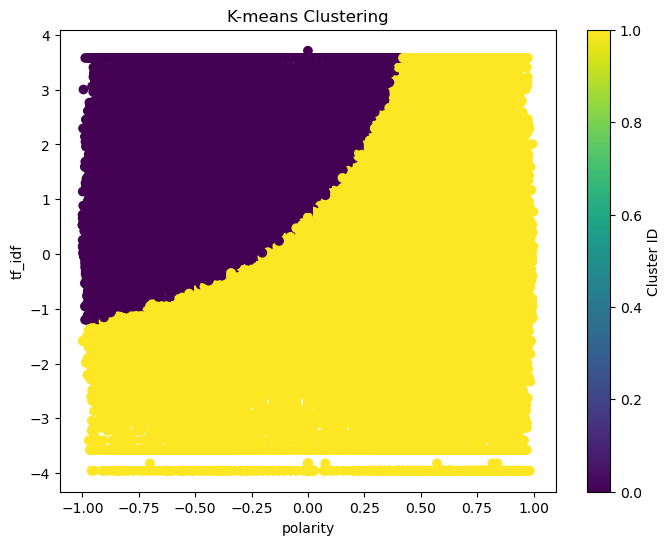

In [46]:
import matplotlib.pyplot as plt

results=df.select("features", "kmeans").collect()
# 解析聚类结果
x_coords = [item["features"][3] for item in results]
y_coords = [item["features"][4] for item in results]
clusters = [item["kmeans"] for item in results]

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=clusters, cmap='viridis', marker='o')
plt.title("K-means Clustering")
plt.xlabel("polarity")
plt.ylabel("tf_idf")
plt.colorbar(label='Cluster ID')
plt.show()

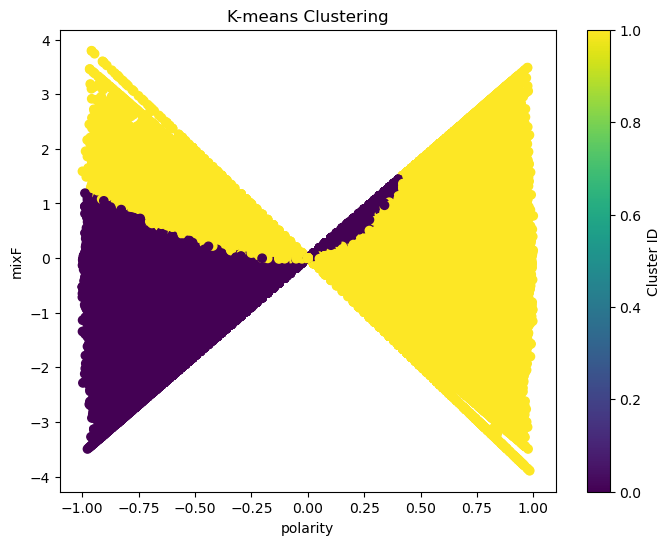

In [37]:
# 解析聚类结果
x_coords = [item["features"][3] for item in results]
y_coords = [item["features"][5] for item in results]
clusters = [item["kmeans"] for item in results]

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, c=clusters, cmap='viridis', marker='o')
plt.title("K-means Clustering")
plt.xlabel("polarity")
plt.ylabel("mixF")
plt.colorbar(label='Cluster ID')
plt.show()

In [35]:
df.select("features", "kmeans").show(truncate=False)

+-------------------------------------------------------------------------------+------+
|features                                                                       |kmeans|
+-------------------------------------------------------------------------------+------+
|[0.0,0.0,71.0,0.07720000296831131,0.5288140773773193,0.04082444682717323]      |1     |
|[1.0,0.0,11.0,-0.12800000607967377,0.5288140773773193,-0.06768820434808731]    |0     |
|[0.0,0.0,657.0,0.7578999996185303,-0.9560711979866028,-0.7246063351631165]     |1     |
|(6,[2,4],[14.0,-0.34601712226867676])                                          |1     |
|(6,[2,3],[208.0,0.599399983882904])                                            |1     |
|[117.0,61.0,14304.0,0.0,-0.2390177994966507,0.0]                               |1     |
|[1.0,0.0,1480.0,0.0,0.25471970438957214,0.0]                                   |1     |
|[1.0,0.0,2324.0,0.8689000010490417,-0.02000725455582142,-0.017384303733706474] |1     |
|(6,[2,4],[23.0,0.312

In [39]:

#feature_columns_xgb = ['scaled_features']
feature_columns_xgb=['likes', 'retweet_count', 'user_followers_count','polarity','TF_IDF','kmeans']
#feature_columns_xgb = ['scaled_features','kmeans']
#feature_columns_xgb = ['kmeans']
#feature_columns=df.columns
print(feature_columns_xgb)
assemblerXGB = VectorAssembler(inputCols=feature_columns_xgb, outputCol="features_clusters")
df = assemblerXGB.transform(df)
df.show(5)

['likes', 'retweet_count', 'user_followers_count', 'polarity', 'TF_IDF', 'kmeans']
+-----+-------------+--------------------+--------+-----------+------------+---------+--------------------+--------------------+------+--------------------+
|likes|retweet_count|user_followers_count|polarity|     TF_IDF|        mixF|President|            features|     scaled_features|kmeans|   features_clusters|
+-----+-------------+--------------------+--------+-----------+------------+---------+--------------------+--------------------+------+--------------------+
|    0|            0|                  71|  0.0772|  0.5288141| 0.040824447|        0|[0.0,0.0,71.0,0.0...|[0.0,0.0,1.966372...|     1|[0.0,0.0,71.0,0.0...|
|    1|            0|                  11|  -0.128|  0.5288141|-0.067688204|        0|[1.0,0.0,11.0,-0....|[0.00341550227123...|     0|[1.0,0.0,11.0,-0....|
|    0|            0|                 657|  0.7579| -0.9560712| -0.72460634|        0|[0.0,0.0,657.0,0....|[0.0,0.0,0.001819...|    

In [40]:
seed = 654321
train_df, test_df = df.randomSplit([0.7, 0.3], seed=seed)
train_df.cache()
test_df.cache()

DataFrame[likes: int, retweet_count: int, user_followers_count: int, polarity: float, TF_IDF: float, mixF: float, President: int, features: vector, scaled_features: vector, kmeans: int, features_clusters: vector]

In [41]:

from xgboost.spark import SparkXGBClassifier

# Initialize the XGBoost classifier
xgb = SparkXGBClassifier(
    enable_sparse_data_optim=True,
    missing=0.0,
    features_col='features_clusters',
    label_col="President",
    prediction_col="prediction",
    numRound=100,
    learning_rate=0.15,
    maxDepth=7,
    alpha=0.0,
    device='cuda'
)




In [42]:
from pyspark.ml import Pipeline

# Set up the pipeline
pipeline = Pipeline(stages=[xgb])

# Train the model
model = pipeline.fit(train_df)

2024-05-12 04:37:00,438 WARNING SparkXGBClassifier: _validate_gpu_params You have enabled GPU in spark local mode. Please make sure your local node has at least 1 GPUs
2024-05-12 04:38:12,378 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cuda', 'learning_rate': 0.15, 'numRound': 100, 'maxDepth': 7, 'alpha': 0.0, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
2024-05-12 04:38:12,722 INFO SparkXGBClassifier: _skip_stage_level_scheduling Stage-level scheduling in xgboost requires spark standalone or local-cluster mode
2024-05-12 04:38:19,321 INFO XGBoost-PySpark: _fit Finished xgboost training!


In [44]:
from numpy import array
#feature importance func
def get_xgb_imp(model, feat_names):
    booster=model.stages[0].get_booster()
    imp_vals = booster.get_fscore()
    imp_dict = {feat_names[int(k[1:])] : v for k, v in imp_vals.items()}  # 适配特征名
    values_array = array(list(imp_dict.values()))  # 转换为 numpy 数组
    total = values_array.sum()  # 计算总和
    return {k: v / total for k, v in imp_dict.items()}  # 归一化特征重要性并返回

{'likes': 0.07608695652173914, 'retweet_count': 0.058953574060427415, 'user_followers_count': 0.23507737656595432, 'polarity': 0.21518054532056005, 'TF_IDF': 0.41396462785556376, 'kmeans': 0.0007369196757553427}


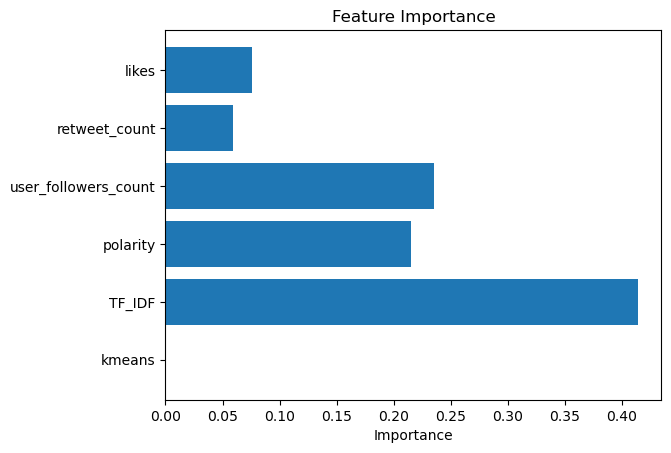

In [45]:
import matplotlib.pyplot as plt

feat_names = ['likes', 'retweet_count', 'user_followers_count','polarity','TF_IDF','kmeans']
imp_dict =get_xgb_imp(model,feat_names)
print(imp_dict)
# 绘图
fig, ax = plt.subplots()
features = list(imp_dict.keys())
importances = list(imp_dict.values())
y_pos = range(len(features))
ax.barh(y_pos, importances, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # 标签从上到下读
ax.set_xlabel('Importance')
ax.set_title('Feature Importance')

plt.show()

In [43]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions
predictions = model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="President", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.8567089994319566


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(xgb.max_depth, [3, 5, 7]) \
    .addGrid(xgb.learning_rate, [0.15, 0.01, 0.001]) \
    .build()



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="President")

In [ ]:
from pyspark.ml.tuning import CrossValidator

cv = CrossValidator(
    estimator=xgb,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3  
)



In [ ]:
cvModel = cv.fit(df)

In [ ]:
print(cvModel.bestModel.getOrDefault('learning_rate'),cvModel.bestModel.getOrDefault('max_depth'))
